### sma(이동 평균)

- 연속된 데이터의 평균을 구함, 시계열 데이터에서 노이즈를 줄이고 전반적인 추세 파악
- 적절한 윈도우(기간)을 설정하여 데이터를 순차적으로 평균내어 계산

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 20.3 MB/s eta 0:00:00


In [3]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_curve, auc, precision_recall_curve, confusion_matrix,
                           classification_report, average_precision_score)
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import calibration_curve
from itertools import cycle

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
data = pd.read_csv('/content/drive/MyDrive/merged_V2.csv')
df = data

In [5]:
# sma 적용
coordinate_columns = [col for col in df.columns if '_x' in col or '_y' in col]

#sma 계산
def apply_sma(df, window_size):
    return df.rolling(window=window_size, min_periods=1).mean()

window_size = 10

for col in coordinate_columns:
    df[f"{col}_SMA"] = apply_sma(df[col], window_size)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


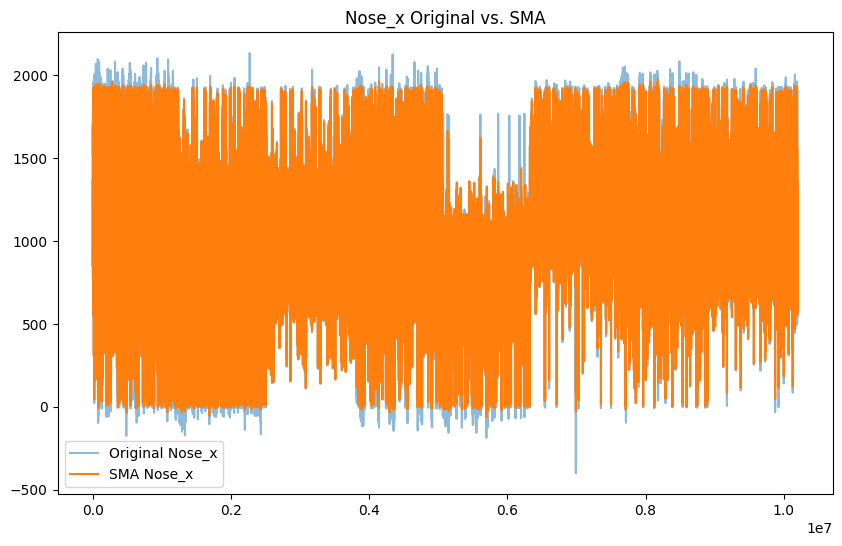

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(data['Nose_x'], label='Original Nose_x', alpha=0.5)
plt.plot(data['Nose_x_SMA'], label='SMA Nose_x')
plt.legend()
plt.title("Nose_x Original vs. SMA")
plt.show()

In [7]:
import numpy as np

def add_adversarial_noise_optimized(df, epsilon=2.0):
    # 필요한 컬럼 리스트
    sma_columns = [col for col in df.columns if col.endswith("_SMA") and ('_x' in col or '_y' in col)]
    # 원본 복사는 최소한으로 (필요한 부분만 복사)
    df_adv = df.copy(deep=False)  # 얕은 복사: 메모리 사용량이 줄어듦 (단, 내부 데이터가 수정되면 원본에도 영향이 있을 수 있음)

    # 모든 SMA 컬럼에 대해 한 번에 noise 행렬 생성 후 적용
    noise = np.random.uniform(-epsilon, epsilon, size=(df_adv.shape[0], len(sma_columns)))
    df_adv.loc[:, sma_columns] = df_adv.loc[:, sma_columns] + noise
    return df_adv

# 최적화된 함수 사용
df_adv = add_adversarial_noise_optimized(df, epsilon=2.0)


In [8]:
df = df.drop(['image_filename', 'Nose_x', 'Nose_y', 'LEye_x', 'LEye_y', 'REye_x', 'REye_y', 'LEar_x', 'LEar_y', 'REar_x', 'REar_y', 'LShoulder_x', 'LShoulder_y', 'RShoulder_x', 'RShoulder_y', 'LElbow_x', 'LElbow_y', 'RElbow_x', 'RElbow_y', 'LWrist_x', 'LWrist_y', 'RWrist_x', 'RWrist_y', 'LHip_x', 'LHip_y', 'RHip_x', 'RHip_y', 'LKnee_x', 'LKnee_y', 'RKnee_x', 'RKnee_y', 'LAnkle_x', 'LAnkle_y', 'RAnkle_x', 'RAnkle_y', 'Head_x', 'Head_y', 'Neck_x', 'Neck_y', 'Hip_x', 'Hip_y', 'LBigToe_x', 'LBigToe_y', 'RBigToe_x', 'RBigToe_y', 'LSmallToe_x', 'LSmallToe_y', 'RSmallToe_x', 'RSmallToe_y', 'LHeel_x', 'LHeel_y', 'RHeel_x', 'RHeel_y', 'gender', 'level','path'], axis=1)

In [9]:
encoder = LabelEncoder()
encoder.fit(data['label'])

df["label"] = encoder.transform(data['label'])
# 0 = jump, 1 = spin, 2 = step

In [10]:
X = df.drop(['label'] , axis=1)
Y = df['label']

print(X.shape)
print(Y.shape)

(10196123, 52)
(10196123,)


In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42, stratify=Y_train
)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print(X_val.shape)
print(Y_val.shape)

(6525518, 52)
(2039225, 52)
(6525518,)
(2039225,)
(1631380, 52)
(1631380,)


In [12]:
!sudo fallocate -l 16G /swapfile
!sudo chmod 600 /swapfile
!sudo mkswap /swapfile
!sudo swapon /swapfile
!free -h  # RAM & Swap 확인

Setting up swapspace version 1, size = 16 GiB (17179865088 bytes)
no label, UUID=86770802-0ff5-42ee-9825-1044037a373b
swapon: /swapfile: swapon failed: Invalid argument
               total        used        free      shared  buff/cache   available
Mem:            50Gi        22Gi       3.7Gi       1.0Mi        24Gi        27Gi
Swap:             0B          0B          0B


In [13]:
# 모델 정의
models = {
    'Extra Trees': ExtraTreesClassifier(n_estimators=50, random_state=42, n_jobs=-1),
    'CatBoost': CatBoostClassifier(iterations=50, random_state=42, verbose=0),
    'LightGBM': LGBMClassifier(n_estimators=50, random_state=42, n_jobs=-1),
    # 'XGBoost': XGBClassifier(n_estimators=50, random_state=42, n_jobs=-1),
    # 'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1),
}

In [14]:
kf = KFold(n_splits=5, shuffle=False)
cv_scores = []

In [15]:
import numpy as np
import gc

# 예측 확률 배열을 float32로 생성하여 메모리 사용 최적화
test_predictions = {
    name: np.zeros((X_test.shape[0], len(np.unique(Y_test))), dtype=np.float64)
    for name in models.keys()
}

# X_test도 numpy 배열로 변환 (한번만 변환)
X_test_np = X_test.values

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\n=== Fold {fold+1} ===")

    # numpy 배열로 변환하여 메모리 사용 최적화
    X_train_fold = X_train.iloc[train_idx].values
    X_val_fold = X_train.iloc[val_idx].values
    Y_train_fold = Y_train.iloc[train_idx].values
    Y_val_fold = Y_train.iloc[val_idx].values

    for name, model in models.items():
        print(f"Training {name}...")

        model.fit(X_train_fold, Y_train_fold)

        # 훈련 세트 성능 평가
        Y_train_pred = model.predict(X_train_fold)
        print("\n--- Training Set Performance ---")
        print(classification_report(Y_train_fold, Y_train_pred))

        # 검증 세트 성능 평가
        Y_val_pred = model.predict(X_val_fold)
        print("\n--- Validation Set Performance ---")
        print(classification_report(Y_val_fold, Y_val_pred))

        # Test Set 예측값 저장 (Soft Voting을 위해 확률 예측값 사용)
        test_predictions[name] += model.predict_proba(X_test_np) / kf.n_splits

    # fold가 끝난 후 사용한 변수 삭제 및 가비지 컬렉션
    del X_train_fold, X_val_fold, Y_train_fold, Y_val_fold
    gc.collect()

# 최종 테스트 세트 평가 (앙상블 방식)
for name, pred_proba in test_predictions.items():
    print(f"\n=== Final Test Evaluation ({name}) - Averaged Over Folds ===")
    # 확률 예측값을 가장 높은 클래스 선택으로 변환
    Y_test_pred = np.argmax(pred_proba, axis=1)
    print("\n--- Test Set Performance ---")
    print(classification_report(Y_test, Y_test_pred))



=== Fold 1 ===
Training Extra Trees...

--- Training Set Performance ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2357516
           1       1.00      1.00      1.00   1681554
           2       1.00      1.00      1.00   1181344

    accuracy                           1.00   5220414
   macro avg       1.00      1.00      1.00   5220414
weighted avg       1.00      1.00      1.00   5220414


--- Validation Set Performance ---
              precision    recall  f1-score   support

           0       0.90      0.94      0.92    590021
           1       0.91      0.90      0.90    420720
           2       0.92      0.86      0.89    294363

    accuracy                           0.91   1305104
   macro avg       0.91      0.90      0.90   1305104
weighted avg       0.91      0.91      0.91   1305104

Training CatBoost...

--- Training Set Performance ---
              precision    recall  f1-score   support

           0      

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.086701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 5220414, number of used features: 52
[LightGBM] [Info] Start training from score -0.794968
[LightGBM] [Info] Start training from score -1.132858
[LightGBM] [Info] Start training from score -1.485924


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



--- Training Set Performance ---
              precision    recall  f1-score   support

           0       0.66      0.77      0.71   2357516
           1       0.59      0.59      0.59   1681554
           2       0.62      0.41      0.49   1181344

    accuracy                           0.63   5220414
   macro avg       0.62      0.59      0.60   5220414
weighted avg       0.63      0.63      0.62   5220414



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



--- Validation Set Performance ---
              precision    recall  f1-score   support

           0       0.66      0.77      0.71    590021
           1       0.59      0.59      0.59    420720
           2       0.61      0.41      0.49    294363

    accuracy                           0.63   1305104
   macro avg       0.62      0.59      0.60   1305104
weighted avg       0.63      0.63      0.62   1305104



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



=== Fold 2 ===
Training Extra Trees...

--- Training Set Performance ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2358246
           1       1.00      1.00      1.00   1681993
           2       1.00      1.00      1.00   1180175

    accuracy                           1.00   5220414
   macro avg       1.00      1.00      1.00   5220414
weighted avg       1.00      1.00      1.00   5220414


--- Validation Set Performance ---
              precision    recall  f1-score   support

           0       0.90      0.93      0.92    589291
           1       0.91      0.90      0.90    420281
           2       0.92      0.86      0.89    295532

    accuracy                           0.91   1305104
   macro avg       0.91      0.90      0.90   1305104
weighted avg       0.91      0.91      0.91   1305104

Training CatBoost...

--- Training Set Performance ---
              precision    recall  f1-score   support

           0      

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.096739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 5220414, number of used features: 52
[LightGBM] [Info] Start training from score -0.794659
[LightGBM] [Info] Start training from score -1.132597
[LightGBM] [Info] Start training from score -1.486914


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



--- Training Set Performance ---
              precision    recall  f1-score   support

           0       0.66      0.77      0.71   2358246
           1       0.59      0.59      0.59   1681993
           2       0.62      0.41      0.49   1180175

    accuracy                           0.63   5220414
   macro avg       0.62      0.59      0.60   5220414
weighted avg       0.63      0.63      0.62   5220414



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



--- Validation Set Performance ---
              precision    recall  f1-score   support

           0       0.66      0.77      0.71    589291
           1       0.59      0.59      0.59    420281
           2       0.62      0.41      0.49    295532

    accuracy                           0.63   1305104
   macro avg       0.62      0.59      0.60   1305104
weighted avg       0.63      0.63      0.62   1305104



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



=== Fold 3 ===
Training Extra Trees...

--- Training Set Performance ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2358321
           1       1.00      1.00      1.00   1681524
           2       1.00      1.00      1.00   1180569

    accuracy                           1.00   5220414
   macro avg       1.00      1.00      1.00   5220414
weighted avg       1.00      1.00      1.00   5220414


--- Validation Set Performance ---
              precision    recall  f1-score   support

           0       0.90      0.94      0.92    589216
           1       0.91      0.90      0.90    420750
           2       0.92      0.86      0.89    295138

    accuracy                           0.91   1305104
   macro avg       0.91      0.90      0.90   1305104
weighted avg       0.91      0.91      0.91   1305104

Training CatBoost...

--- Training Set Performance ---
              precision    recall  f1-score   support

           0      

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.242522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 5220414, number of used features: 52
[LightGBM] [Info] Start training from score -0.794627
[LightGBM] [Info] Start training from score -1.132876
[LightGBM] [Info] Start training from score -1.486580


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



--- Training Set Performance ---
              precision    recall  f1-score   support

           0       0.66      0.77      0.71   2358321
           1       0.59      0.59      0.59   1681524
           2       0.62      0.41      0.49   1180569

    accuracy                           0.63   5220414
   macro avg       0.62      0.59      0.60   5220414
weighted avg       0.63      0.63      0.62   5220414



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



--- Validation Set Performance ---
              precision    recall  f1-score   support

           0       0.66      0.77      0.71    589216
           1       0.59      0.59      0.59    420750
           2       0.61      0.41      0.49    295138

    accuracy                           0.63   1305104
   macro avg       0.62      0.59      0.60   1305104
weighted avg       0.63      0.63      0.62   1305104



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



=== Fold 4 ===
Training Extra Trees...

--- Training Set Performance ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2358676
           1       1.00      1.00      1.00   1681572
           2       1.00      1.00      1.00   1180167

    accuracy                           1.00   5220415
   macro avg       1.00      1.00      1.00   5220415
weighted avg       1.00      1.00      1.00   5220415


--- Validation Set Performance ---
              precision    recall  f1-score   support

           0       0.90      0.93      0.92    588861
           1       0.91      0.90      0.90    420702
           2       0.92      0.86      0.89    295540

    accuracy                           0.91   1305103
   macro avg       0.91      0.90      0.90   1305103
weighted avg       0.91      0.91      0.91   1305103

Training CatBoost...

--- Training Set Performance ---
              precision    recall  f1-score   support

           0      

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.117074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 5220415, number of used features: 52
[LightGBM] [Info] Start training from score -0.794476
[LightGBM] [Info] Start training from score -1.132848
[LightGBM] [Info] Start training from score -1.486921


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



--- Training Set Performance ---
              precision    recall  f1-score   support

           0       0.66      0.77      0.71   2358676
           1       0.59      0.59      0.59   1681572
           2       0.61      0.41      0.49   1180167

    accuracy                           0.63   5220415
   macro avg       0.62      0.59      0.60   5220415
weighted avg       0.63      0.63      0.62   5220415



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



--- Validation Set Performance ---
              precision    recall  f1-score   support

           0       0.66      0.77      0.71    588861
           1       0.59      0.59      0.59    420702
           2       0.61      0.41      0.49    295540

    accuracy                           0.63   1305103
   macro avg       0.62      0.59      0.60   1305103
weighted avg       0.63      0.63      0.62   1305103



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



=== Fold 5 ===
Training Extra Trees...

--- Training Set Performance ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2357389
           1       1.00      1.00      1.00   1682453
           2       1.00      1.00      1.00   1180573

    accuracy                           1.00   5220415
   macro avg       1.00      1.00      1.00   5220415
weighted avg       1.00      1.00      1.00   5220415


--- Validation Set Performance ---
              precision    recall  f1-score   support

           0       0.90      0.94      0.92    590148
           1       0.91      0.90      0.90    419821
           2       0.92      0.86      0.89    295134

    accuracy                           0.91   1305103
   macro avg       0.91      0.90      0.90   1305103
weighted avg       0.91      0.91      0.91   1305103

Training CatBoost...

--- Training Set Performance ---
              precision    recall  f1-score   support

           0      

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.228478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 5220415, number of used features: 52
[LightGBM] [Info] Start training from score -0.795022
[LightGBM] [Info] Start training from score -1.132324
[LightGBM] [Info] Start training from score -1.486577


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



--- Training Set Performance ---
              precision    recall  f1-score   support

           0       0.66      0.77      0.71   2357389
           1       0.59      0.59      0.59   1682453
           2       0.62      0.41      0.49   1180573

    accuracy                           0.63   5220415
   macro avg       0.62      0.59      0.60   5220415
weighted avg       0.63      0.63      0.62   5220415



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



--- Validation Set Performance ---
              precision    recall  f1-score   support

           0       0.66      0.77      0.71    590148
           1       0.59      0.59      0.59    419821
           2       0.61      0.41      0.49    295134

    accuracy                           0.63   1305103
   macro avg       0.62      0.59      0.60   1305103
weighted avg       0.63      0.63      0.62   1305103



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



=== Final Test Evaluation (Extra Trees) - Averaged Over Folds ===

--- Test Set Performance ---
              precision    recall  f1-score   support

           0       0.91      0.94      0.93    921106
           1       0.92      0.91      0.92    656960
           2       0.93      0.88      0.90    461159

    accuracy                           0.92   2039225
   macro avg       0.92      0.91      0.92   2039225
weighted avg       0.92      0.92      0.92   2039225


=== Final Test Evaluation (CatBoost) - Averaged Over Folds ===

--- Test Set Performance ---
              precision    recall  f1-score   support

           0       0.67      0.76      0.72    921106
           1       0.60      0.60      0.60    656960
           2       0.61      0.45      0.52    461159

    accuracy                           0.64   2039225
   macro avg       0.63      0.60      0.61   2039225
weighted avg       0.64      0.64      0.63   2039225


=== Final Test Evaluation (LightGBM) - Average


=== Confusion Matrix (Extra Trees) ===


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(


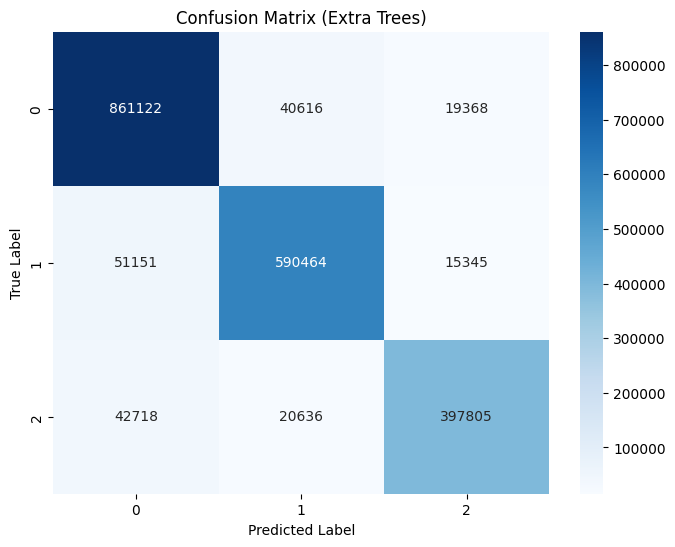


=== Confusion Matrix (CatBoost) ===


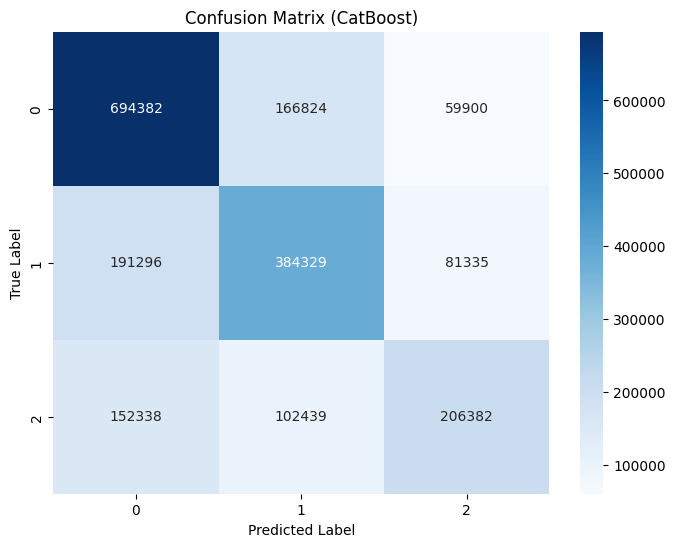


=== Confusion Matrix (LightGBM) ===


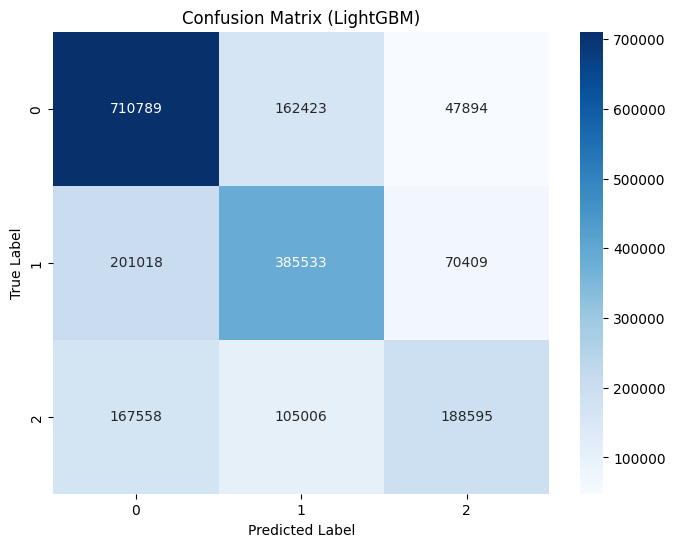

In [16]:
class_names = np.unique(Y_test)

for name, model in models.items():
    print(f"\n=== Confusion Matrix ({name}) ===")

    Y_test_pred = model.predict(X_test)

    cm = confusion_matrix(Y_test, Y_test_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f'Confusion Matrix ({name})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


=== Evaluating Extra Trees ===


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(


Extra Trees Y_test_pred shape: (2039225,)
Extra Trees Y_test_pred (first 5): [0 1 1 1 0]


<ipython-input-17-07e9d1d5386d>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classwise_error.index, y=classwise_error.values, palette="viridis")


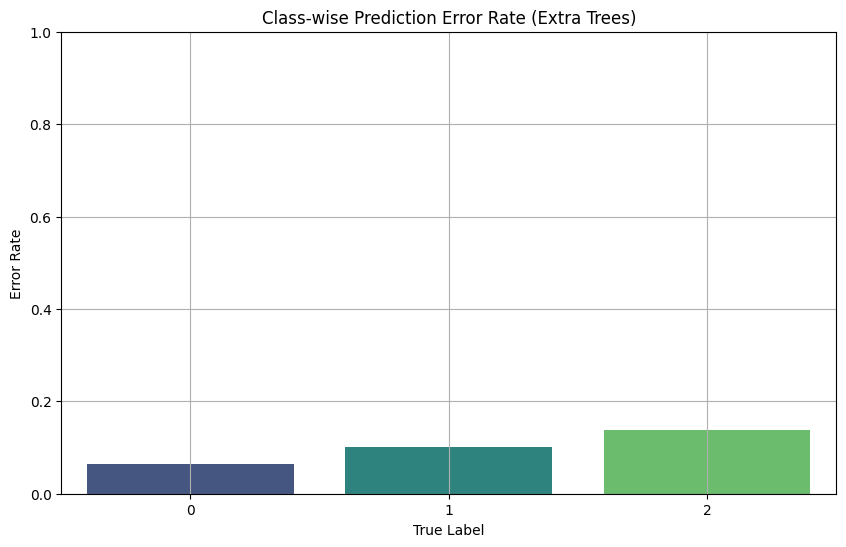

True Label
0    0.065122
1    0.101218
2    0.137380
Name: Error, dtype: float64

=== Evaluating CatBoost ===
CatBoost Y_test_pred shape: (2039225, 1)
CatBoost Y_test_pred (first 5): [0 1 1 1 0]


<ipython-input-17-07e9d1d5386d>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classwise_error.index, y=classwise_error.values, palette="viridis")


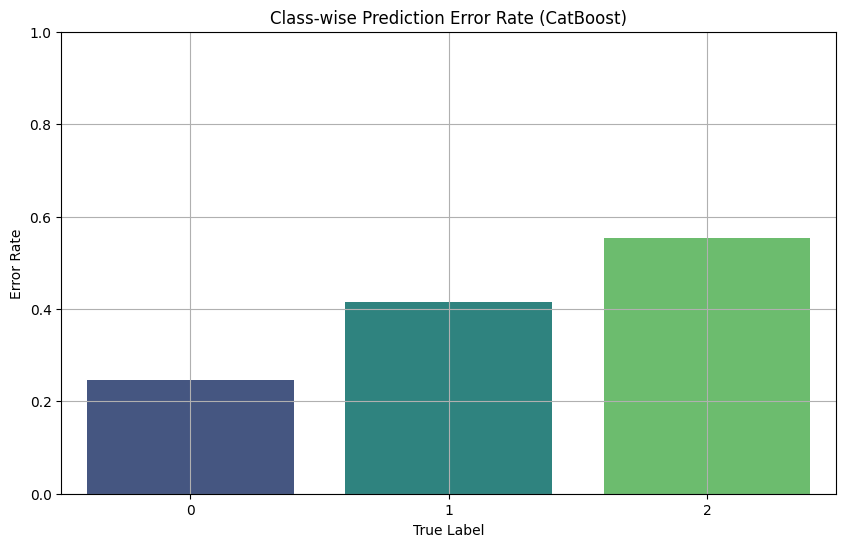

True Label
0    0.246143
1    0.414989
2    0.552471
Name: Error, dtype: float64

=== Evaluating LightGBM ===
LightGBM Y_test_pred shape: (2039225,)
LightGBM Y_test_pred (first 5): [0 1 1 1 0]


<ipython-input-17-07e9d1d5386d>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classwise_error.index, y=classwise_error.values, palette="viridis")


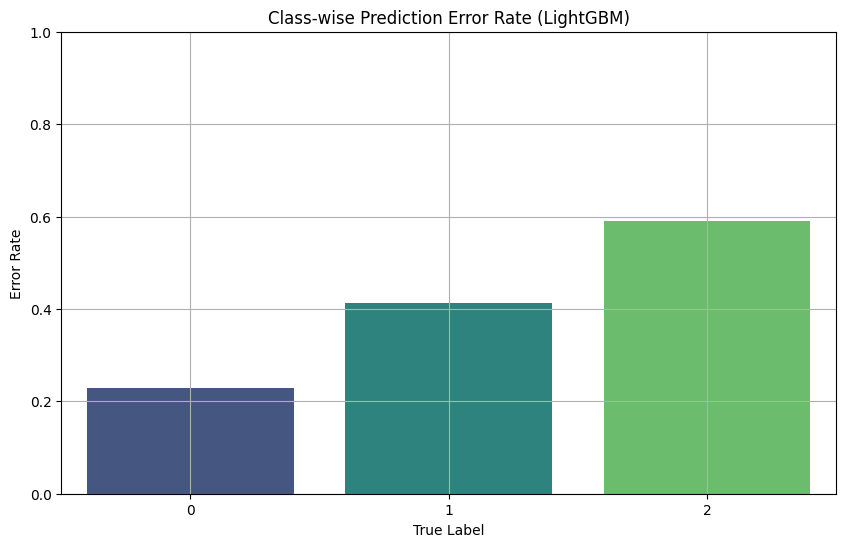

True Label
0    0.228331
1    0.413156
2    0.591041
Name: Error, dtype: float64


In [17]:
for name, model in models.items():
    print(f"\n=== Evaluating {name} ===")

    # 예측값 생성
    Y_test_pred = model.predict(X_test)

    # 예측값 차원 확인
    print(f"{name} Y_test_pred shape: {Y_test_pred.shape}")

    # 1차원 변환 (필요할 경우)
    if Y_test_pred.ndim > 1:
        if Y_test_pred.shape[1] > 1:
            print(f"Warning: {name} predict() returned probabilities! Using argmax().")
            Y_test_pred = Y_test_pred.argmax(axis=1)
        else:
            Y_test_pred = Y_test_pred.ravel()

    print(f"{name} Y_test_pred (first 5): {Y_test_pred[:5]}")

    # 예측 오류 분석
    error = pd.DataFrame({
        "True Label": Y_test,
        "Predicted Label": Y_test_pred
    })

    error["Error"] = (error["True Label"] != error["Predicted Label"]).astype(int)
    classwise_error = error.groupby("True Label")["Error"].mean()

    # 클래스별 오류 비율 시각화
    plt.figure(figsize=(10, 6))
    sns.barplot(x=classwise_error.index, y=classwise_error.values, palette="viridis")
    plt.title(f"Class-wise Prediction Error Rate ({name})")
    plt.xlabel("True Label")
    plt.ylabel("Error Rate")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

    print(classwise_error)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(



=== ROC Curve Analysis (Extra Trees) ===


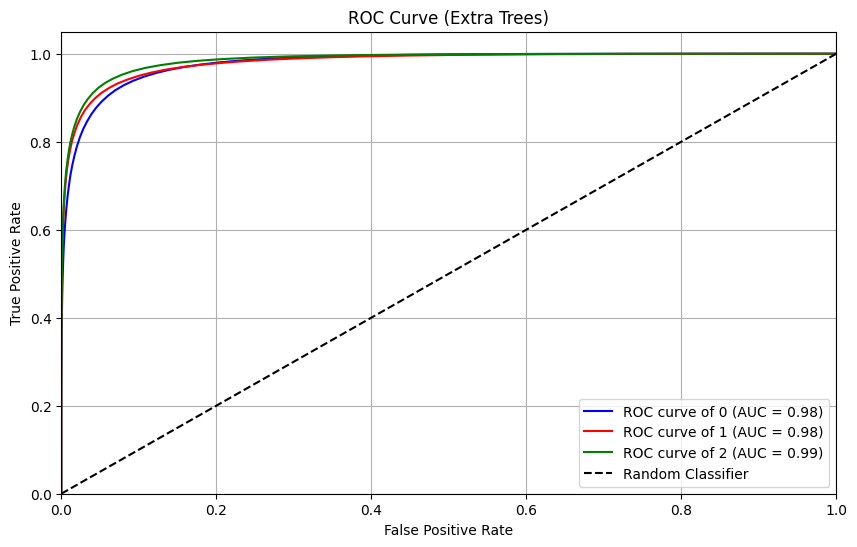


=== AUC Scores ===
0: 0.979
1: 0.981
2: 0.985

=== ROC Curve Analysis (CatBoost) ===


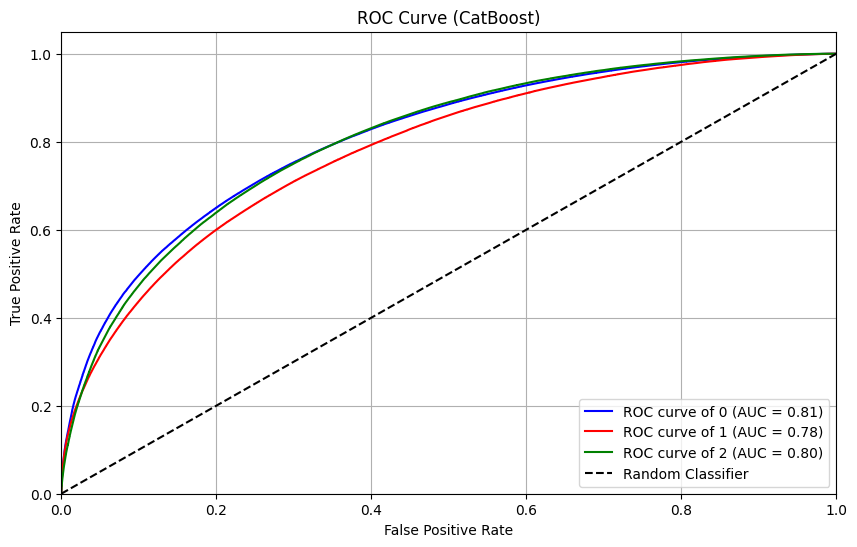


=== AUC Scores ===
0: 0.808
1: 0.782
2: 0.805

=== ROC Curve Analysis (LightGBM) ===


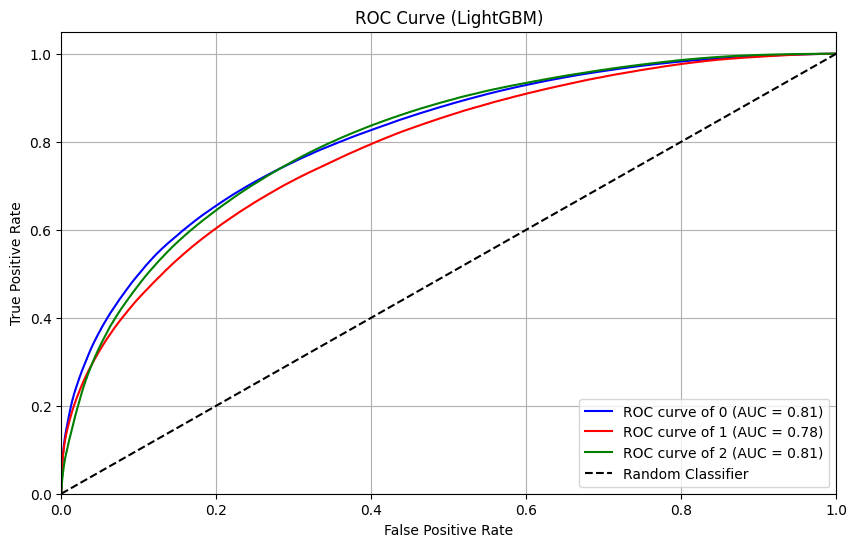


=== AUC Scores ===
0: 0.810
1: 0.784
2: 0.808


In [18]:
for name, model in models.items():
    print(f"\n=== ROC Curve Analysis ({name}) ===")

    # 예측 확률 생성
    y_pred_proba = model.predict_proba(X_test)

    # 클래스별 FPR, TPR, AUC 저장
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    auc_scores = {}

    # 클래스별 ROC 곡선 계산
    for i, class_name in enumerate(np.unique(Y)):
        fpr[i], tpr[i], _ = roc_curve(
            (Y_test == class_name).astype(int),  # 다중 클래스 ROC 변환
            y_pred_proba[:, i]
        )
        roc_auc[i] = auc(fpr[i], tpr[i])
        auc_scores[class_name] = roc_auc[i]

    # ROC 커브 그리기
    plt.figure(figsize=(10, 6))
    colors = cycle(['blue', 'red', 'green'])

    for i, (color, class_name) in enumerate(zip(colors, np.unique(Y))):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            label=f'ROC curve of {class_name} (AUC = {roc_auc[i]:.2f})'
        )

    # 완벽한 예측선을 추가
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({name})')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # AUC 점수 출력
    print("\n=== AUC Scores ===")
    for class_name, score in auc_scores.items():
        print(f"{class_name}: {score:.3f}")




=== Precision-Recall Curve Analysis (Extra Trees) ===


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(


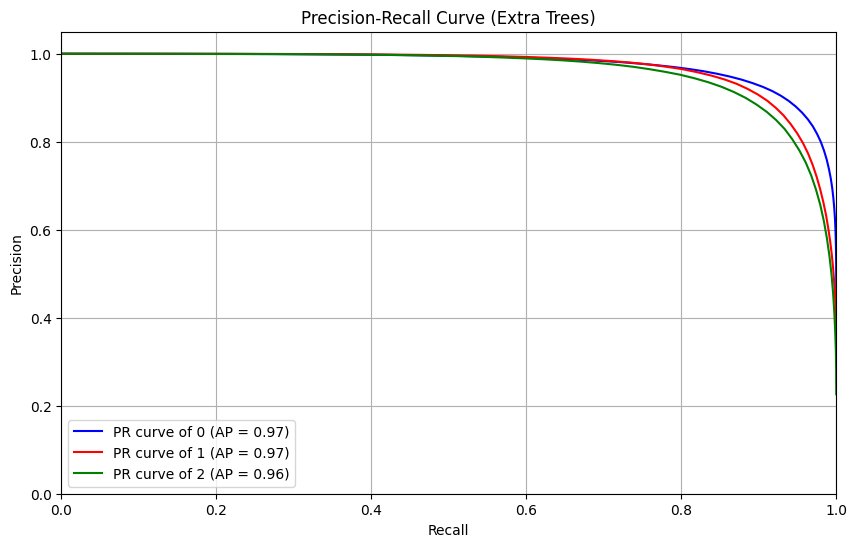


=== Average Precision Scores ===
0: 0.974
1: 0.966
2: 0.958

=== Precision-Recall Curve Analysis (CatBoost) ===


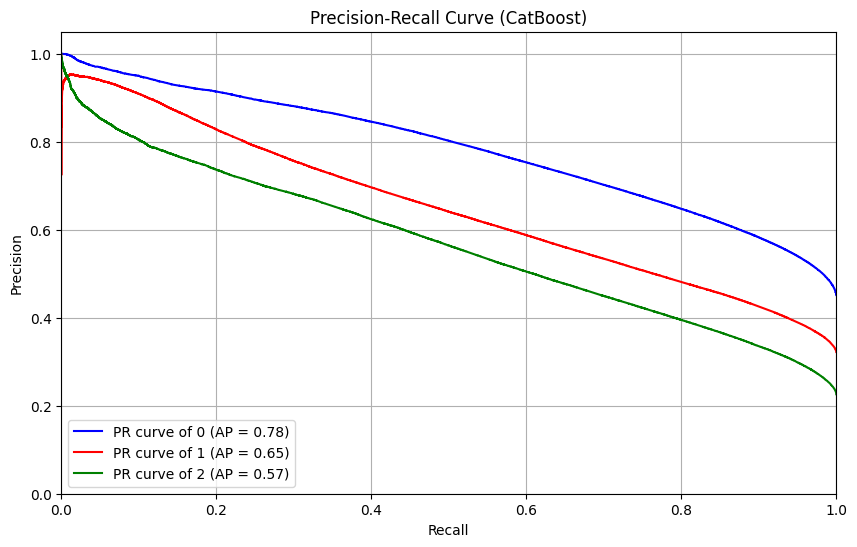


=== Average Precision Scores ===
0: 0.782
1: 0.651
2: 0.568

=== Precision-Recall Curve Analysis (LightGBM) ===


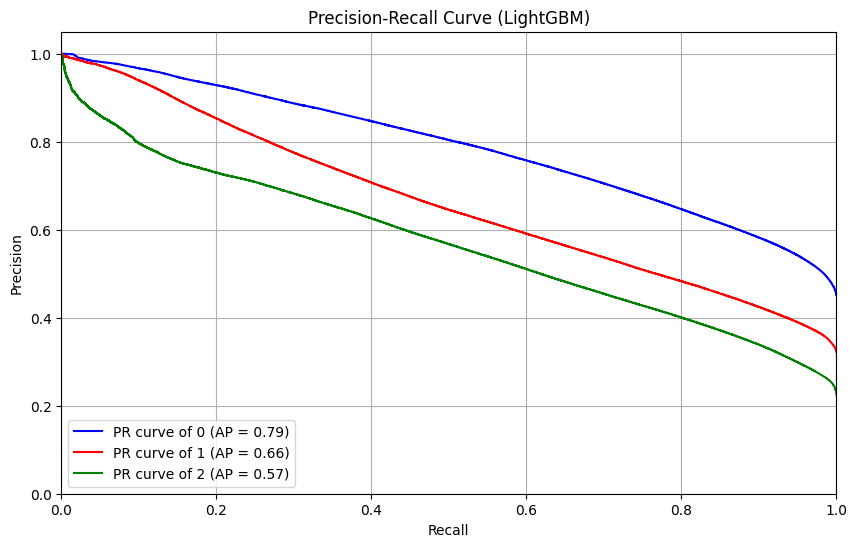


=== Average Precision Scores ===
0: 0.787
1: 0.663
2: 0.570


In [19]:
for name, model in models.items():
    print(f"\n=== Precision-Recall Curve Analysis ({name}) ===")

    # 예측 확률 생성
    y_pred_proba = model.predict_proba(X_test)

    # 클래스별 Precision, Recall, AP 저장
    precision = dict()
    recall = dict()
    avg_precision = dict()
    ap_scores = {}

    # 클래스별 PR 곡선 계산
    for i, class_name in enumerate(np.unique(Y)):
        precision[i], recall[i], _ = precision_recall_curve(
            (Y_test == class_name).astype(int),  # 다중 클래스 PR 변환
            y_pred_proba[:, i]
        )
        avg_precision[i] = average_precision_score(
            (Y_test == class_name).astype(int),
            y_pred_proba[:, i]
        )
        ap_scores[class_name] = avg_precision[i]

    # PR 커브 그리기
    plt.figure(figsize=(10, 6))
    colors = cycle(['blue', 'red', 'green'])

    for i, (color, class_name) in enumerate(zip(colors, np.unique(Y))):
        plt.plot(
            recall[i],
            precision[i],
            color=color,
            label=f'PR curve of {class_name} (AP = {avg_precision[i]:.2f})'
        )

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ({name})')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

    # AP 점수 출력
    print("\n=== Average Precision Scores ===")
    for class_name, score in ap_scores.items():
        print(f"{class_name}: {score:.3f}")


=== Calibration Analysis (Extra Trees) ===


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(


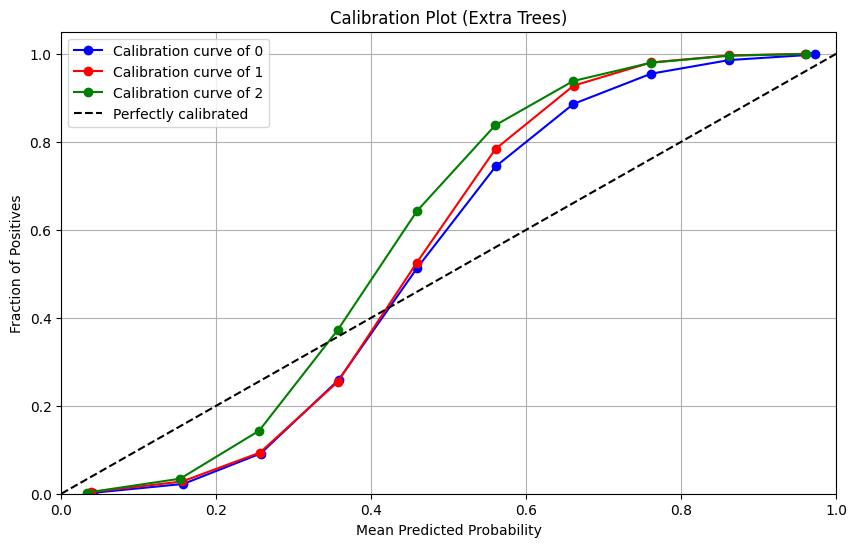


=== Calibration Scores ===
0: 0.124
1: 0.138
2: 0.141

=== Calibration Analysis (CatBoost) ===


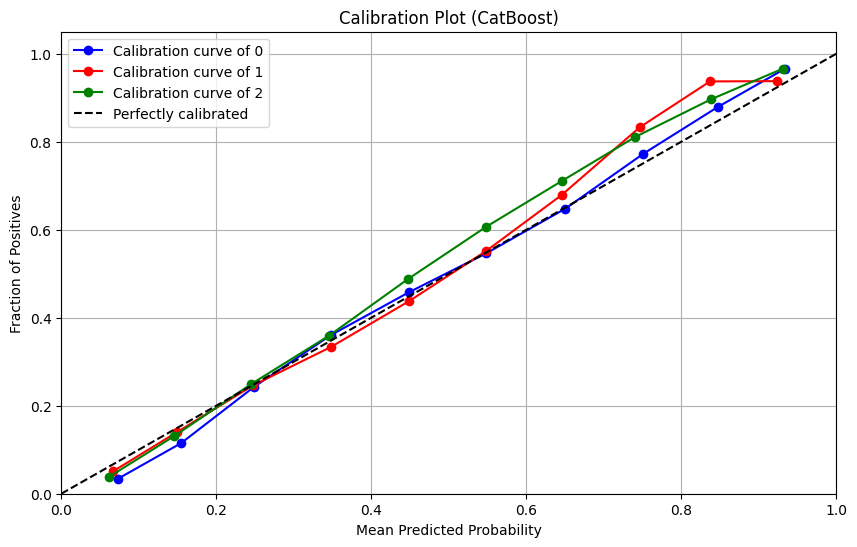


=== Calibration Scores ===
0: 0.020
1: 0.029
2: 0.038

=== Calibration Analysis (LightGBM) ===


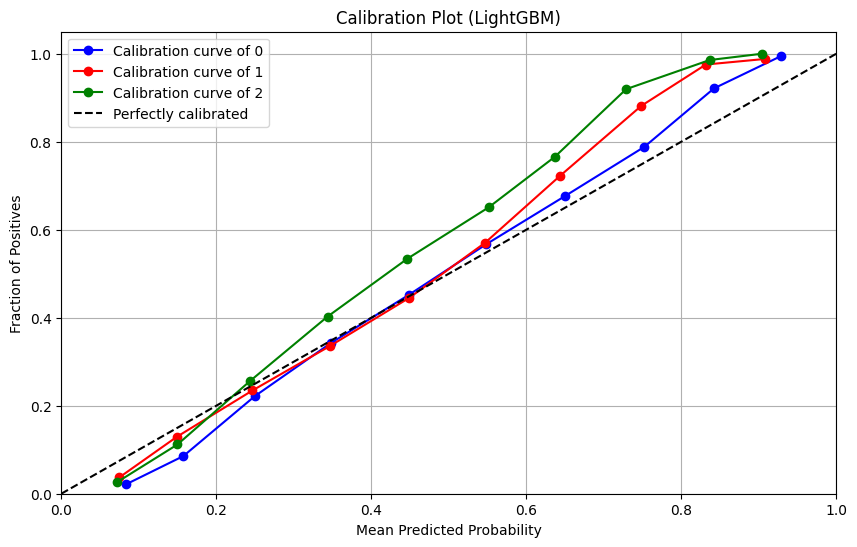


=== Calibration Scores ===
0: 0.040
1: 0.054
2: 0.091


In [20]:
for name, model in models.items():
    print(f"\n=== Calibration Analysis ({name}) ===")

    # 예측 확률 생성
    y_pred_proba = model.predict_proba(X_test)

    # 클래스별 Calibration 정보 저장
    prob_true = dict()
    prob_pred = dict()
    calibration_scores = {}

    # 그래프 색상 설정
    colors = cycle(['blue', 'red', 'green'])

    # 캘리브레이션 곡선 계산
    plt.figure(figsize=(10, 6))
    for i, (color, class_name) in enumerate(zip(colors, np.unique(Y))):
        prob_true[i], prob_pred[i] = calibration_curve(
            (Y_test == class_name).astype(int),  # 다중 클래스 변환
            y_pred_proba[:, i],
            n_bins=10
        )
        # 신뢰도 계산 (절대 오차의 평균)
        calibration_scores[class_name] = np.mean(np.abs(prob_true[i] - prob_pred[i]))

        # Calibration Curve 그리기
        plt.plot(
            prob_pred[i],
            prob_true[i],
            marker='o',
            color=color,
            label=f'Calibration curve of {class_name}'
        )

    # 완벽히 보정된 모델 기준선 추가
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'Calibration Plot ({name})')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

    # Calibration Score 출력
    print("\n=== Calibration Scores ===")
    for class_name, score in calibration_scores.items():
        print(f"{class_name}: {score:.3f}")